In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj
import math
import os
from shapely.geometry import Point,Polygon,shape
from shapely.geometry import LineString
##以下两行代码的作用是全显示不折叠，非常耗内存，非特殊情况不要生效
#pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',None)

In [49]:
listid=[1340]##循环的话，这里就输入多个线路的编号

    站点上车人数 STATIONNAME STATIONNO  往返站序  单程站序     上下行标记  单程站序2  上下行
0      3.0       沙头客运站    112894   1.0   1.0  100225.0    2.0  1.0
1      0.0      沙头中心小学    112274   2.0   2.0  100225.0    3.0  1.0
2     10.0      施沙路陈祠路    112264   3.0   3.0  100225.0    4.0  1.0
3      2.0    施沙路人民中路东    112904   4.0   4.0  100225.0    5.0  1.0
4      0.0         红旗桥    102813   5.0   5.0  100225.0    6.0  1.0
5      0.0         新生组    112912   6.0   6.0  100225.0    7.0  1.0
6      0.0         通长组    112922   7.0   7.0  100225.0    8.0  1.0
7      1.0         万字组    112933   8.0   8.0  100225.0    9.0  1.0
8      0.0       育新村委会    112943   9.0   9.0  100225.0   10.0  1.0
9      0.0         务本组    112954  10.0  10.0  100225.0   11.0  1.0
10     1.0         团结组    112983  11.0  11.0  100225.0   12.0  1.0
11     0.0      人民滩村委会    112993  12.0  12.0  100225.0   13.0  1.0
12     1.0       人民滩十组    129821  13.0  13.0  100225.0   14.0  1.0
13     0.0       人民滩九组    113004  14.0  14.0  100225.0   15.0 

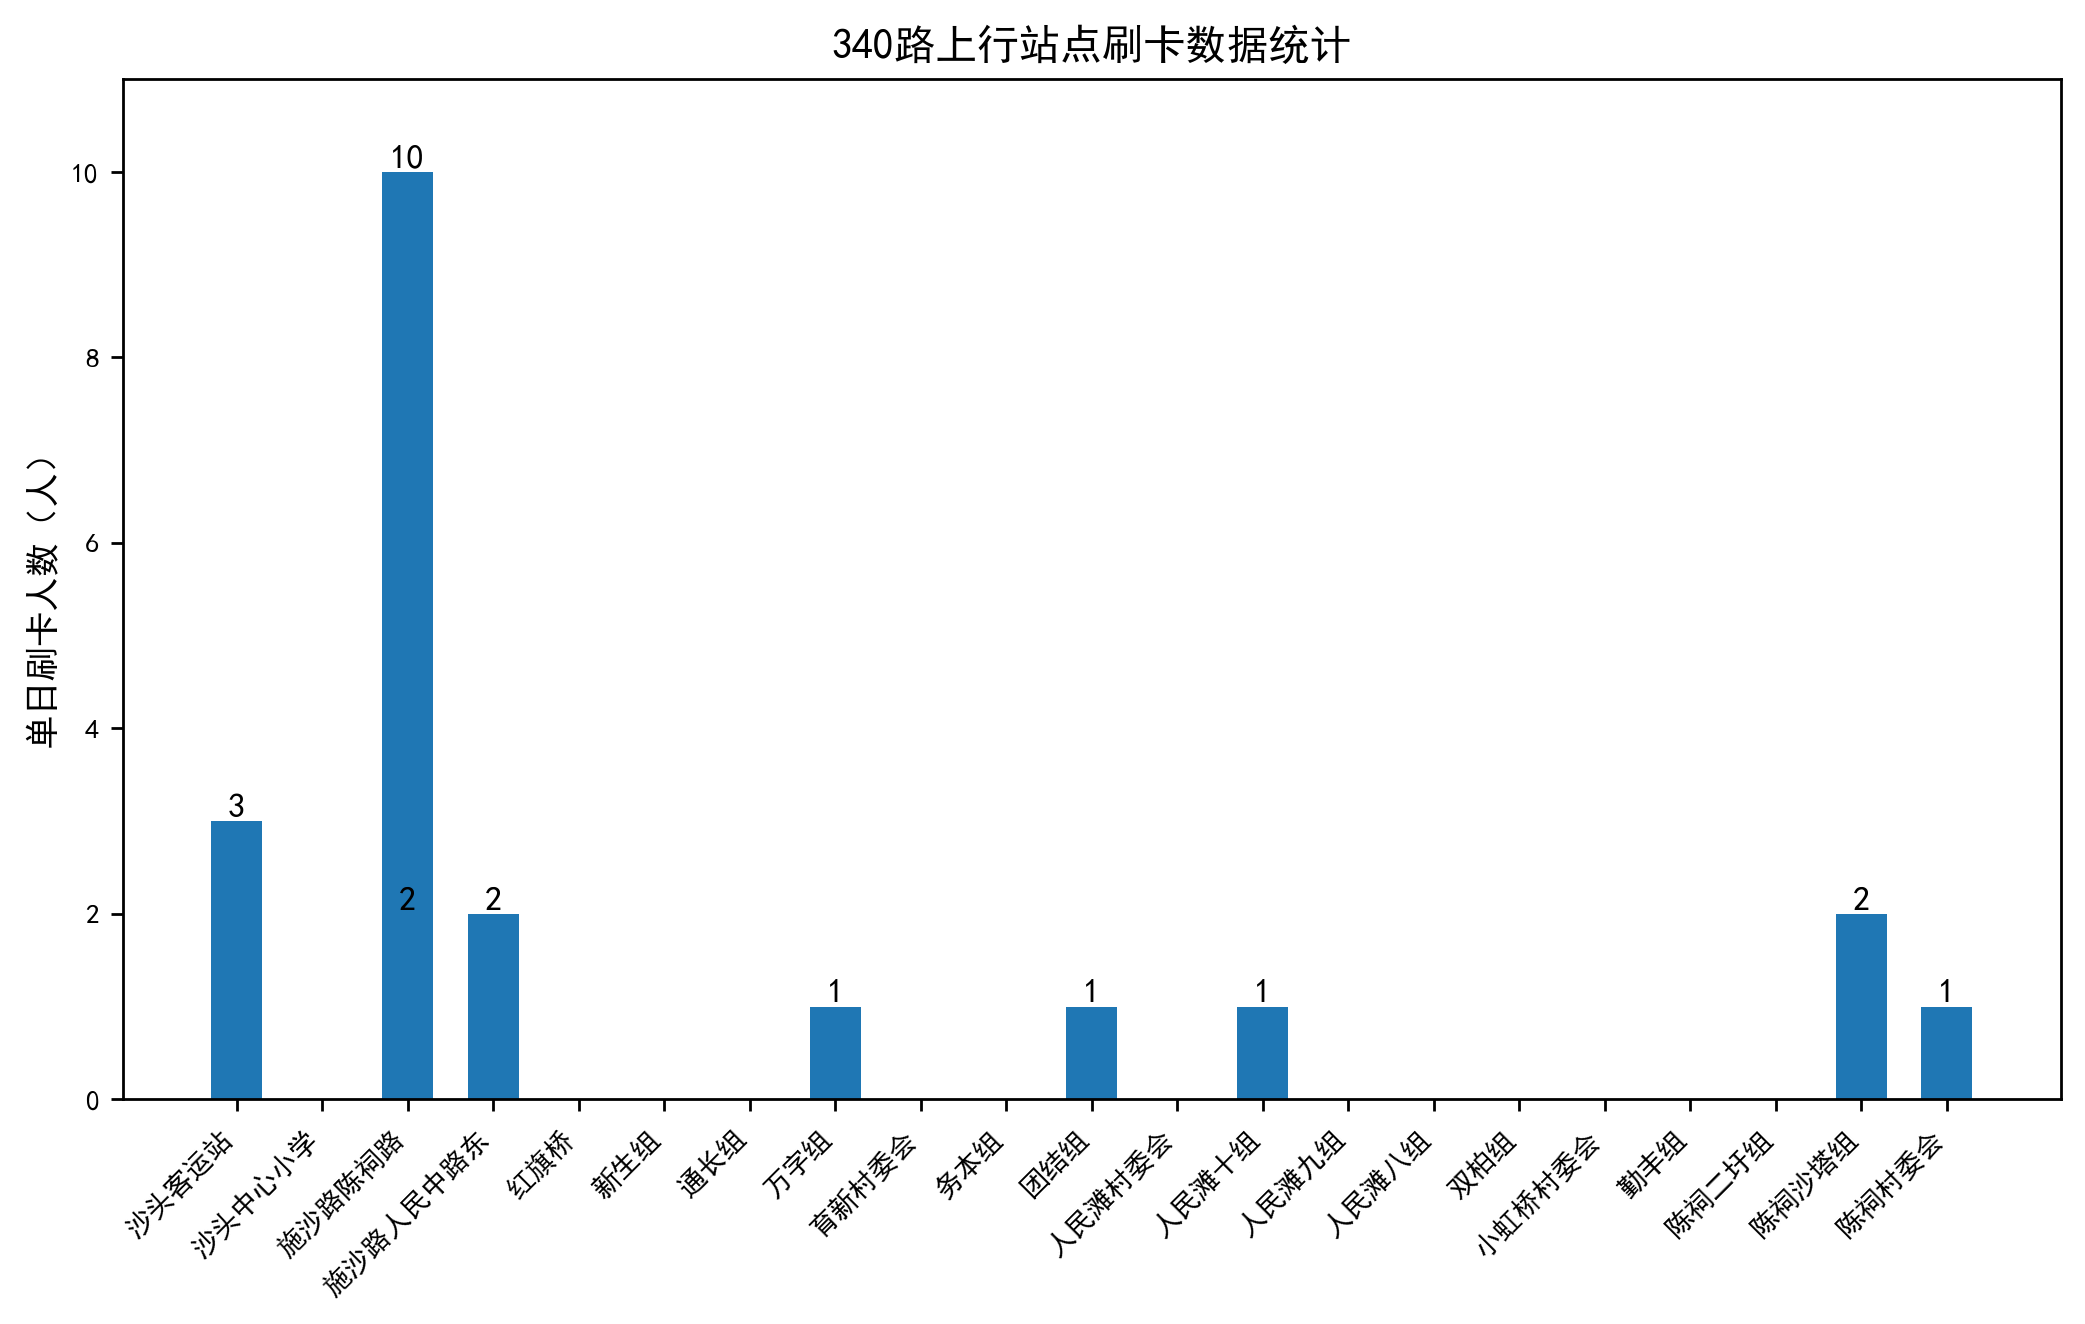

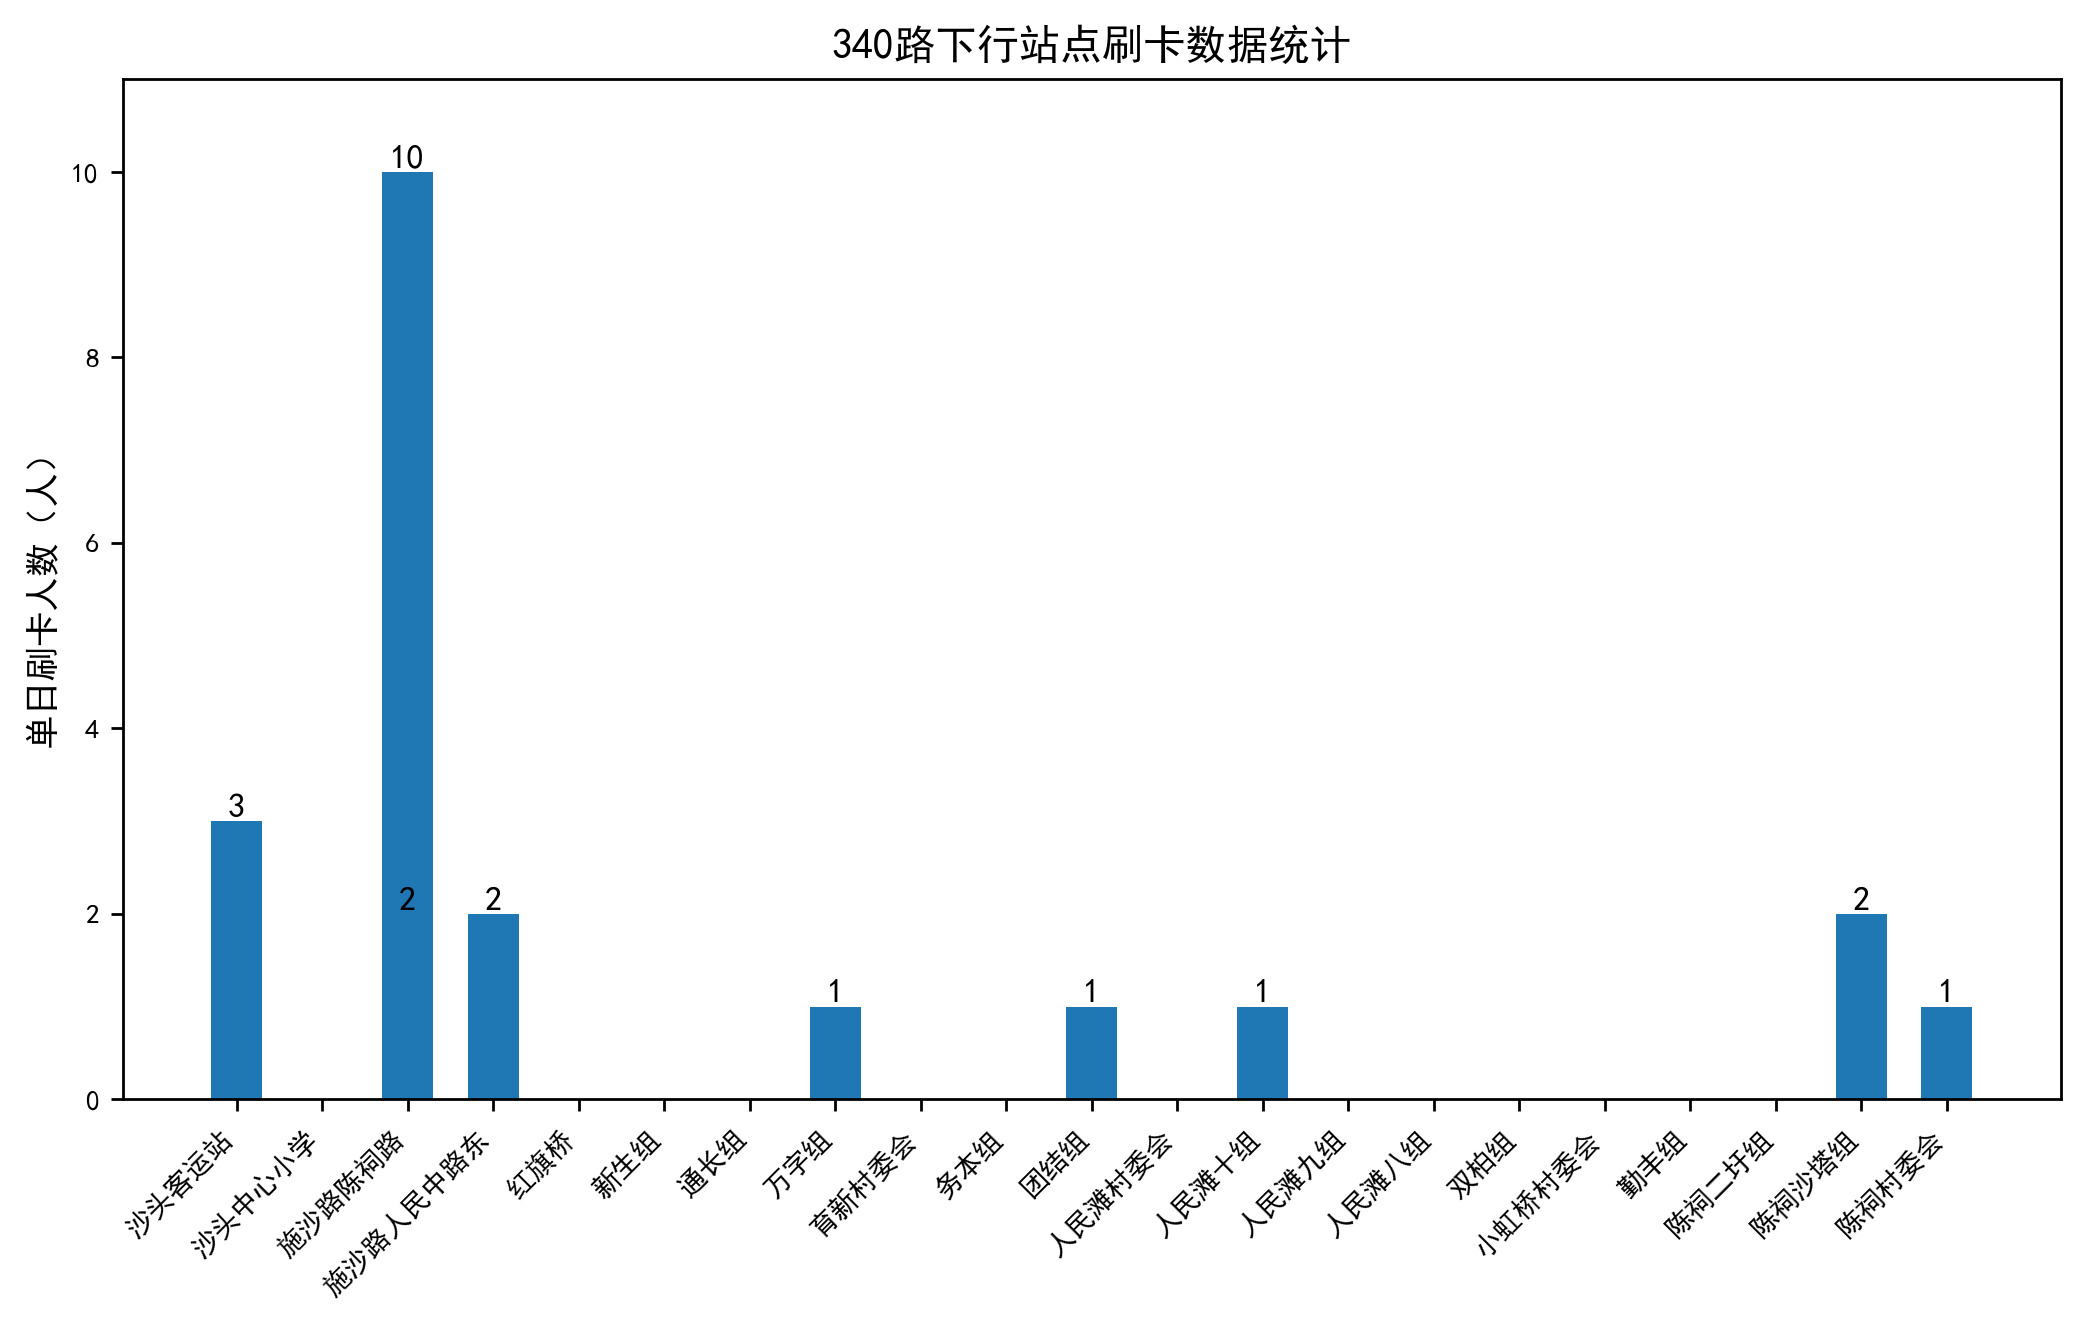

In [50]:
for xianluid in listid :
    allstop=gpd.read_file(r'D:\项目\扬州\BUSGPS\ROUTESTATION.csv',encoding = 'utf-8')
    mytest=allstop.loc[allstop.ROUTEID==str(xianluid)]
    mytest=mytest.filter(items=['???RSEGMENTSID', 'ROUTEID', 'SEGMENTID', 'STATIONID',
           'SNGSERIALID', 'STATIONTYPEID', 'STATIONTYPENAME', 'DUALSERIALID', 'STATIONNAME'])
    mytest[['SEGMENTID','SNGSERIALID','DUALSERIALID']]= mytest[['SEGMENTID','SNGSERIALID','DUALSERIALID']].apply(pd.to_numeric)
    mytest.sort_values(by=['SEGMENTID','SNGSERIALID','DUALSERIALID'],inplace=True)##要转化数据格式，不然是按照字符串正则排序
    stations=mytest['STATIONID']
    ##获取站点的具体信息
    STATION= gpd.read_file(r'D:\项目\扬州\BUSGPS\STATION.csv',encoding = 'utf-8')
    test=STATION.filter(items=['???STATIONID', 'STATIONNO', 'STATIONNAME', 'STATIONTYPE',
           'STATIONTYPENAME', 'ROADNAME', 'LONGITUDE','LATITUDE'])
    mystation=test[test['???STATIONID'].isin(stations)]
    ##合并信息
    st=mytest.merge(mystation,how='outer',left_on='STATIONID',right_on='???STATIONID',left_index=False,right_index=False,sort=False,suffixes=('_linestation', '_station'),copy=True,indicator=False,validate=None)
    ##生成站点的点要素
    stop=st[['ROUTEID', 'SEGMENTID', 'STATIONID', 'SNGSERIALID', 'STATIONTYPEID',  'DUALSERIALID','STATIONNAME_linestation', 'STATIONNO',
     'STATIONTYPE','ROADNAME', 'LONGITUDE', 'LATITUDE']]
    stop.columns=['ROUTEID', '上下行标记', 'STATIONID', '单程站序', 'STATIONTYPEID',  '往返站序','STATIONNAME', 'STATIONNO',
     'STATIONTYPE','ROADNAME', 'LONGITUDE', 'LATITUDE']
    data=pd.read_excel(r'D:\项目\扬州\公交刷卡数据\上车数量统计\上下车集计13\\'+str(xianluid)+'.xlsx')
    data[['站点编号1']]= data[['站点编号1']].astype(str)
    stop[['STATIONNO']]= stop[['STATIONNO']].astype(str)
    st2=data.merge(stop,how='outer',left_on='站点编号1',right_on='STATIONNO',left_index=False,right_index=False,sort=False,suffixes=('_data', '_stop'),copy=True,indicator=False,validate=None)
    ##生成站点的点要素
    data2=st2.filter(items=['站点上车人数', 'STATIONNAME','STATIONNO', '往返站序', '单程站序',
           '上下行标记'])
    data2[['往返站序','单程站序','上下行标记']]= data2[['往返站序','单程站序','上下行标记']].apply(pd.to_numeric)
    #data2.sort_values(by=['上下行标记','往返站序','单程站序'],inplace=True)##要转化数据格式，不然是按照字符串正则排序
    data2.sort_values(by=['往返站序'],inplace=True)
    data2['单程站序2']=data2['单程站序'].shift(-1)
    data2['上下行']=data2['单程站序2']-data2['单程站序']
    pd.set_option('display.max_columns',None)
    pd.set_option('display.max_rows',None)
    data2.reset_index(drop=True,inplace=True)
    ##填充缺失值
    #data2=data2.loc[0:len(data2)-2]
    data2=data2.fillna(0)
    data2=data2.loc[data2.STATIONNAME!=data2.STATIONNO]
    yichang=data.loc[data.站点编号1=='异常刷卡']
    if len(yichang)!=0:
        yichang2=yichang['站点上车人数'].iloc[0]
        yichangjun=int(yichang2/len(data2))
        data2=data2.loc[0:len(data2)-2]
        
        #data2=data2.loc[0:len(data2)-8]
    else:
        #data2=data2.loc[0:len(data2)-2]
        yichangjun=0
    sxx=data2.loc[data2.上下行!=1.0]
    sxx.sort_values(by='上下行',inplace=True)
    if len(sxx)==0:
        shangxingdata=data2
        xiaxingdata=data2
    else:
        shangxingdata=data2.iloc[0:sxx.index[0]+1]
        xiaxingdata=data2.iloc[sxx.index[0]+1:len(data2)]
    shangxingdata['站点上车人数']=shangxingdata['站点上车人数']+yichangjun
    xiaxingdata['站点上车人数']=xiaxingdata['站点上车人数']+yichangjun
    shangxingdata['站点上车人数']=shangxingdata['站点上车人数']+yichangjun
    xiaxingdata['站点上车人数']=xiaxingdata['站点上车人数']+yichangjun
    print(shangxingdata,xiaxingdata)
    shangxing=shangxingdata[['站点上车人数', 'STATIONNAME','STATIONNO', '往返站序', '单程站序', '上下行标记']]
    xiaxing=xiaxingdata[['站点上车人数', 'STATIONNAME','STATIONNO', '往返站序', '单程站序', '上下行标记']]
    hightest=shangxingdata.站点上车人数.max()
    hightest2=xiaxingdata.站点上车人数.max()
    hightes3=max(hightest,hightest2)
    hightes3
    import math
    a=math.ceil(hightes3/10)
    b=a*11
    allxianlu=pd.read_excel(r'F:\扬州公交GPS数据\ic线路对应2021-11-25.xls')
    allxianlu2=allxianlu.loc[allxianlu.线路id==xianluid]
    xianlumingcheng=allxianlu2['线路名称'].iloc[0]
    #接下来是绘制柱状图
    import matplotlib.pyplot as plt
    # 这两行代码解决 plt 中文显示的问题
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    x_data = shangxingdata['STATIONNAME'].tolist()
    y_data = shangxingdata['站点上车人数'].tolist()
    if len(shangxingdata)>30:
        fig = plt.figure(figsize=(14,6),dpi=250)
        plt.bar(x_data, y_data,width = 0.6)
    elif len(shangxingdata)>10:
        fig = plt.figure(figsize=(10,6),dpi=250)
        plt.bar(x_data, y_data,width = 0.6)
    else:
        fig = plt.figure(figsize=(6,6),dpi=250)
        plt.bar(x_data, y_data,width = 0.4)
    ax = plt.gca()
    # 为了避免x轴日期刻度标签的重叠，设置x轴刻度自动展现，并且45度倾斜
    fig.autofmt_xdate(rotation = 45)
    plt.tick_params(labelsize=8)##x轴字体大小

    plt.title(str(xianlumingcheng)+'上行'+'站点刷卡数据统计')
    plt.ylabel('单日刷卡人数（人）')
    plt.ylim(0,b)
    for i,j in zip(x_data,y_data): 
        if j!=0:
            plt.text(i,j,"%d"%j,ha="center",va="bottom")
    plt.savefig(os.path.join(r'D:\项目\扬州\公交刷卡数据\上车数量统计\图片\\'+str(xianluid)+'上行.jpg'))
    plt.show()
    import matplotlib.pyplot as plt
    # 这两行代码解决 plt 中文显示的问题
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    x_data = xiaxingdata['STATIONNAME'].tolist()
    y_data = xiaxingdata['站点上车人数'].tolist()
    if len(shangxingdata)>30:
        fig = plt.figure(figsize=(14,6),dpi=250)
        plt.bar(x_data, y_data,width = 0.6)
    elif len(shangxingdata)>10:
        fig = plt.figure(figsize=(10,6),dpi=250)
        plt.bar(x_data, y_data,width = 0.6)
    else:
        fig = plt.figure(figsize=(6,6),dpi=250)
        plt.bar(x_data, y_data,width = 0.4)
    ax = plt.gca()
    # 为了避免x轴日期刻度标签的重叠，设置x轴刻度自动展现，并且45度倾斜
    fig.autofmt_xdate(rotation = 45)
    plt.tick_params(labelsize=8)##x轴字体大小

    plt.title(str(xianlumingcheng)+'下行'+'站点刷卡数据统计')
    plt.ylabel('单日刷卡人数（人）')
    plt.ylim(0,b)
    for i,j in zip(x_data,y_data): 
        if j!=0:
            plt.text(i,j,"%d"%j,ha="center",va="bottom")
    plt.savefig(os.path.join(r'D:\项目\扬州\公交刷卡数据\上车数量统计\图片\\'+str(xianluid)+'下行.jpg'))
    plt.show()

In [13]:
yichangjun

5